In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sps
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# import GLM model
from pyglmnet import GLM

# create regularization parameters for model
reg_lambda = np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1))
model = GLM(distr='poissonexp', verbose=False, alpha=0.05, 
            max_iter=1000, learning_rate=1e-5, 
            reg_lambda=reg_lambda, eta=4.0)

### Linearize the exponential at large values

$$
J = \sum_i \lambda_i - y_i \log \lambda_i
$$

where 

\lambda_i = 
\begin{cases}
    \exp(z_i), & \text{if}\ z_i \leq \eta \\
    \\
     \exp(\eta)z_i + (1-\eta)\exp(\eta), & \text{if}\ z_i \gt \eta
\end{cases}

and 

$$
z_i = \beta_0 + \sum_j \beta_j x_{ij}
$$

Taking gradients,

$$
\frac{\partial J}{\partial \beta_j} = \sum_i \frac{\partial J}{\partial \lambda_i} \frac{\partial \lambda_i}{\partial z_i} \frac{\partial z_i}{\partial \beta_j}
$$

$$
\frac{\partial J}{\partial \beta_0} = 
\begin{cases}
    \sum_i \Big(\lambda_i - y_i\Big), & \text{if}\ z_i \leq \eta \\
    \\
    \exp(\eta) \sum_i \Big(1 - \frac{\lambda_i}{y_i}\Big), & \text{if}\ z_i \gt \eta
\end{cases}
$$

$$
\frac{\partial J}{\partial \beta_j} = 
\begin{cases}
    \sum_i \Big(\lambda_i - y_i\Big)x_{ij}, & \text{if}\ z_i \leq \eta \\
    \\
    \exp(\eta) \sum_i \Big(1 - \frac{\lambda_i}{y_i}\Big)x_{ij}, & \text{if}\ z_i \gt \eta
\end{cases}
$$


In [30]:
z = np.linspace(0., 10., 100)
qu = model.qu(z)

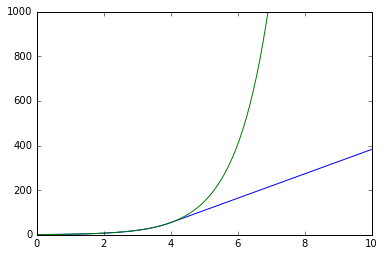

In [31]:
plt.plot(z, qu)
plt.hold
plt.plot(z, np.exp(z))
plt.ylim([0, 1000])
plt.show()

In [32]:
# Dataset size
N = 10000
p = 100

# Coefficients

# baseline term
beta0 = np.random.normal(0.0, 1.0, 1)
# sparse model terms
beta = sps.rand(p,1,0.1)
beta = np.array(beta.todense())

# Training data
Xr = np.random.normal(0.0, 1.0, [N,p])
yr = model.simulate(beta0, beta, Xr)

# Test data
Xt = np.random.normal(0.0, 1.0, [N,p])
yt = model.simulate(beta0, beta, Xt)

In [33]:
# Fit model to training data
scaler = StandardScaler().fit(Xr)
model.fit(scaler.transform(Xr),yr);

In [34]:
grad_beta0, grad_beta = model.grad_L2loss(model.fit_[-1]['beta0'], model.fit_[-1]['beta'], 0.01, Xr, yr)
grad_beta[:5]

array([[-27.23690522],
       [ 63.58744623],
       [-41.7403622 ],
       [-17.54809735],
       [-10.23549695]])

In [35]:
m = model[-1]
this_model_param = m.fit_
yrhat = m.predict(scaler.transform(Xr))
ythat = m.predict(scaler.transform(Xt))


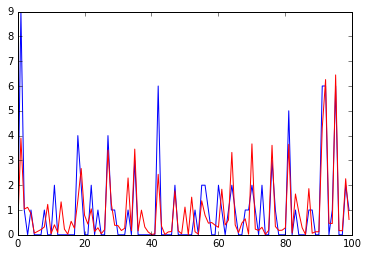

In [36]:
# Visualize fits
plt.plot(yt[:100])
plt.hold(True)
plt.plot(ythat[:100], 'r')
plt.show()

In [37]:
m.pseudo_R2(yt, ythat, np.mean(yr))

0.6898553867879621